In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import fisher_exact
from scipy import stats
import seaborn as sns

import matplotlib.font_manager as font_manager
import pandas as pd
font_dirs = ['/mnt/e/Misc/Python_Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
matplotlib.rcParams['font.family'] = 'arial'

In [2]:
count = np.array([5, 12])
nobs = np.array([83, 99])
stat, pval = proportions_ztest(count, nobs)

In [3]:
d50_counts = pd.read_csv('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/d50_countings_osvz_markers_v2_check.tsv',sep='\t',index_col=0)

In [4]:
d50_counts

,Vesicle No.,Protocol,Cell Line,Gene,No. Positive Cells,No. DAPI,No. SOX2+ Cells
Organoid No.,,,,,,,
1,V1,Dual SMAD-i,ZIP8K8,SOX2+LIFR,81,1103,230
1,V2,Dual SMAD-i,ZIP8K8,SOX2+LIFR,15,289,97
1,V3,Dual SMAD-i,ZIP8K8,SOX2+LIFR,15,386,127
1,V4,Dual SMAD-i,ZIP8K8,SOX2+LIFR,38,668,159
1,V5,Dual SMAD-i,ZIP8K8,SOX2+LIFR,78,417,126
...,...,...,...,...,...,...,...
1,V1,Triple-i,FOK1,SOX2+HOPX,8,268,32
1,V2,Triple-i,FOK1,SOX2+HOPX,9,171,36
1,V3,Triple-i,FOK1,SOX2+HOPX,6,136,21


In [5]:
d50_counts['n_cells_per_DAPI'] = d50_counts['No. Positive Cells']/d50_counts['No. DAPI']
d50_counts['n_cells_per_SOX2'] = d50_counts['No. Positive Cells']/d50_counts['No. SOX2+ Cells']

In [26]:
len(d50_counts[(d50_counts['Gene'] == 'SOX2+LIFR') & (d50_counts['Protocol'] == 'Dual SMAD-i')])

16

In [18]:
def ttest(a, b, axis=0, equal_var=True, nan_policy='propagate',
          alternative='two.sided'):        
    tval, pval = stats.ttest_ind(a=a, b=b, axis=axis, equal_var=equal_var,
                           nan_policy=nan_policy)
    if alternative == 'greater':
        if tval < 0:
            pval = 1 - pval / 2
        else:
            pval = pval / 2
    elif alternative == 'less':
        if tval < 0:
            pval /= 2
        else:
            pval = 1 - pval / 2
    else:
        assert alternative == 'two.sided'
    return tval, pval

0.014644073778898176


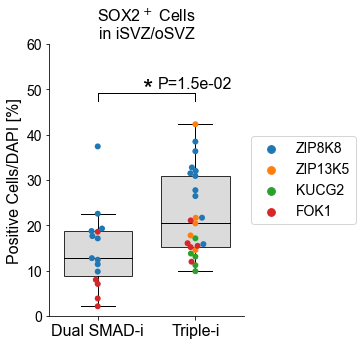

In [19]:
plt.figure(figsize=(3.5,5))

d50_counts_sub = d50_counts[d50_counts['Gene'].isin(['TBR2'])]
d50_counts_sub = d50_counts_sub.sort_values(by='Cell Line',ascending=False)
frac_pos_sbnx = d50_counts_sub[d50_counts_sub['Protocol']=='Triple-i']['No. SOX2+ Cells']/d50_counts_sub[d50_counts_sub['Protocol']=='Triple-i']['No. DAPI']
frac_pos_sbn = d50_counts_sub[d50_counts_sub['Protocol']=='Dual SMAD-i']['No. SOX2+ Cells']/d50_counts_sub[d50_counts_sub['Protocol']=='Dual SMAD-i']['No. DAPI']
d50_counts_sub['n_SOX2_per_DAPI'] = d50_counts_sub['No. SOX2+ Cells']/d50_counts_sub['No. DAPI']

t, p = ttest(frac_pos_sbn, frac_pos_sbnx,alternative='two.sided')#,alternative='less')

ax = sns.boxplot(x="Protocol", y='n_SOX2_per_DAPI', data=d50_counts_sub,showfliers=False,color='white',
                linewidth=1,width=0.7)#,linecolor='black')
ax = sns.swarmplot(x="Protocol", y='n_SOX2_per_DAPI', data=d50_counts_sub,hue="Cell Line",s=6)#".25")
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('Positive Cells/DAPI [%]',fontsize=16)
plt.xlabel('')

# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('lightgray')#'slateblue')
    box.set_alpha(0.8)

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         ax.lines[j].set_color('black')

plt.ylim(plt.ylim()[0],plt.ylim()[1]+(plt.ylim()[1]-plt.ylim()[0])*0.3)
y_cut = (plt.ylim()[1]-plt.ylim()[0])*0.03

y=max(max(frac_pos_sbnx),max(frac_pos_sbn))+y_cut*2
for j,idx in enumerate([[0,1]]):
    y_new = y+y_cut*2
    plt.plot([idx[0],idx[1]],[y_new,y_new],'-',color='black',linewidth=1)
    plt.plot([idx[0],idx[0]],[y_new-y_cut,y_new],'-',color='black',linewidth=1)
    plt.plot([idx[1],idx[1]],[y_new-y_cut,y_new],'-',color='black',linewidth=1)
    if p < 0.0001: star_t = '****'
    elif p < 0.001: star_t = '***'
    elif p < 0.01: star_t = '**'
    elif p < 0.05: star_t = '*'
    else: star_t = 'n.s.'
    if star_t == 'n.s.':
        plt.annotate(star_t,xy=(idx[0]+0.37*(idx[1]-idx[0]),y_new+0.005),fontsize=20)
        plt.annotate('P='+"{:.1e}".format(p),
                     xy=(idx[0]+0.5*(idx[1]-idx[0])-len(star_t)*0.05+len(star_t)*0.16,y_new+0.01),fontsize=16)
    else:
        plt.annotate(star_t,xy=(idx[0]+0.5*(idx[1]-idx[0])-len(star_t)*0.05,y_new-0.01),fontsize=26)
        plt.annotate('P='+"{:.1e}".format(p),
                     xy=(idx[0]+0.5*(idx[1]-idx[0])-len(star_t)*0.05+len(star_t)*0.16,y_new+0.01),fontsize=16)
    print(p)

plt.ylim(0,plt.ylim()[1])
plt.xticks([0,1],['Dual SMAD-i','Triple-i'],fontsize=16)
plt.title('SOX2$^+$ Cells\nin iSVZ/oSVZ',fontsize=16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.yticks(plt.yticks()[0],[str(int(x*100)) for x in plt.yticks()[0]],fontsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)

plt.savefig('figures/fig5/sox2_per_osvz_area.with_points.png',dpi=500,bbox_inches='tight')
plt.savefig('figures/fig5/sox2_per_osvz_area.with_points.pdf',bbox_inches='tight')

0.014644073778898176


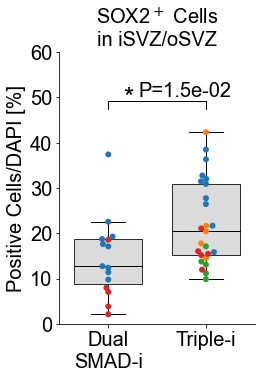

In [23]:
plt.figure(figsize=(3.5,5))

d50_counts_sub = d50_counts[d50_counts['Gene'].isin(['TBR2'])]
d50_counts_sub = d50_counts_sub.sort_values(by='Cell Line',ascending=False)
frac_pos_sbnx = d50_counts_sub[d50_counts_sub['Protocol']=='Triple-i']['No. SOX2+ Cells']/d50_counts_sub[d50_counts_sub['Protocol']=='Triple-i']['No. DAPI']
frac_pos_sbn = d50_counts_sub[d50_counts_sub['Protocol']=='Dual SMAD-i']['No. SOX2+ Cells']/d50_counts_sub[d50_counts_sub['Protocol']=='Dual SMAD-i']['No. DAPI']
d50_counts_sub['n_SOX2_per_DAPI'] = d50_counts_sub['No. SOX2+ Cells']/d50_counts_sub['No. DAPI']

t, p = ttest(frac_pos_sbn, frac_pos_sbnx,alternative='two.sided')#,alternative='less')

ax = sns.boxplot(x="Protocol", y='n_SOX2_per_DAPI', data=d50_counts_sub,showfliers=False,color='white',
                linewidth=1,width=0.7)#,linecolor='black')
ax = sns.swarmplot(x="Protocol", y='n_SOX2_per_DAPI', data=d50_counts_sub,hue="Cell Line",s=6)#".25")
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.ylabel('Positive Cells/DAPI [%]',fontsize=20)
plt.xlabel('')

# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('lightgray')#'slateblue')
    box.set_alpha(0.8)

    # iterate over whiskers and median lines
    for j in range(5*i,5*(i+1)):
         ax.lines[j].set_color('black')

plt.ylim(plt.ylim()[0],plt.ylim()[1]+(plt.ylim()[1]-plt.ylim()[0])*0.3)
y_cut = (plt.ylim()[1]-plt.ylim()[0])*0.03

y=max(max(frac_pos_sbnx),max(frac_pos_sbn))+y_cut*2
for j,idx in enumerate([[0,1]]):
    y_new = y+y_cut*2
    plt.plot([idx[0],idx[1]],[y_new,y_new],'-',color='black',linewidth=1)
    plt.plot([idx[0],idx[0]],[y_new-y_cut,y_new],'-',color='black',linewidth=1)
    plt.plot([idx[1],idx[1]],[y_new-y_cut,y_new],'-',color='black',linewidth=1)
    if p < 0.0001: star_t = '****'
    elif p < 0.001: star_t = '***'
    elif p < 0.01: star_t = '**'
    elif p < 0.05: star_t = '*'
    else: star_t = 'n.s.'
    if star_t == 'n.s.':
        plt.annotate(star_t,xy=(idx[0]+0.4*(idx[1]-idx[0]),y_new+0.005),fontsize=20)
        plt.annotate('P='+"{:.1e}".format(p),
                     xy=(idx[0]+0.5*(idx[1]-idx[0])-len(star_t)*0.5+len(star_t)*0.1,y_new+0.01),fontsize=20)
    else:
        plt.annotate(star_t,xy=(idx[0]+0.2*(idx[1]-idx[0])-len(star_t)*0.05,y_new-0.01),fontsize=26)
        plt.annotate('P='+"{:.1e}".format(p),
                     xy=(idx[0]+0.25*(idx[1]-idx[0])-len(star_t)*0.1+len(star_t)*0.16,y_new+0.01),fontsize=20)
    print(p)

plt.ylim(0,plt.ylim()[1])
plt.xticks([0,1],['Dual\nSMAD-i','Triple-i'],fontsize=20)
plt.title('SOX2$^+$ Cells\nin iSVZ/oSVZ',fontsize=20)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.yticks(plt.yticks()[0],[str(int(x*100)) for x in plt.yticks()[0]],fontsize=20)
plt.legend('',frameon=False)

plt.savefig('figures/fig5/sox2_per_osvz_area.with_points.no_legend.png',dpi=500,bbox_inches='tight')
plt.savefig('figures/fig5/sox2_per_osvz_area.with_points.no_legend.pdf',bbox_inches='tight')

SOX2+HOPX 0.0019915345316120587 **
SOX2+LIFR 0.00014095030265959537 ***
SOX2+PTPRZ1 0.00011438659710264326 ***
TBR2 2.2016513899473655e-07 ****
SOX2+LIFR+PTPRZ1 2.851430497483592e-07 ****


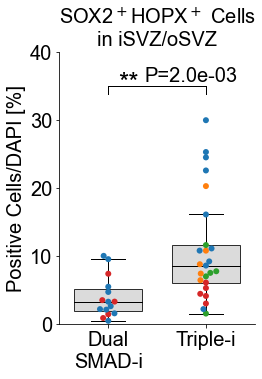

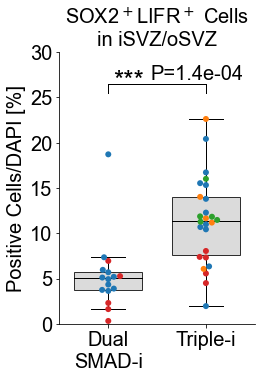

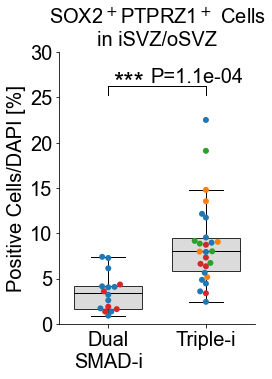

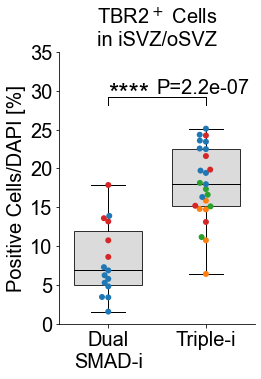

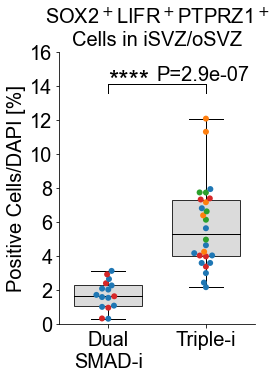

In [21]:
for gene in ['SOX2+HOPX','SOX2+LIFR','SOX2+PTPRZ1','TBR2','SOX2+LIFR+PTPRZ1']:
    
    plt.figure(figsize=(3.5,5))
    d50_counts_sub = d50_counts[d50_counts['Gene']==gene]
    d50_counts_sub = d50_counts_sub.sort_values(by='Cell Line',ascending=False)
    frac_pos_sbnx = d50_counts_sub[d50_counts_sub['Protocol']=='Triple-i']['n_cells_per_DAPI']
    frac_pos_sbn = d50_counts_sub[d50_counts_sub['Protocol']=='Dual SMAD-i']['n_cells_per_DAPI']
    t, p = ttest(frac_pos_sbn, frac_pos_sbnx,alternative='two.sided')#,alternative='less')#
    
    ax = sns.boxplot(x="Protocol", y='n_cells_per_DAPI', data=d50_counts_sub,showfliers=False,color='white',
                    linewidth=1,width=0.7)#,linecolor='black')
    ax = sns.swarmplot(x="Protocol", y='n_cells_per_DAPI', data=d50_counts_sub,hue="Cell Line",s=6)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.ylabel('Positive Cells/DAPI [%]',fontsize=20)
    plt.xlabel('')

    # iterate over boxes
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('lightgray')#'slateblue')
        box.set_alpha(0.8)

        # iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
             ax.lines[j].set_color('black')
    
    plt.ylim(plt.ylim()[0],plt.ylim()[1]+(plt.ylim()[1]-plt.ylim()[0])*0.3)
    y_cut = (plt.ylim()[1]-plt.ylim()[0])*0.03
    y=max(max(frac_pos_sbnx),max(frac_pos_sbn))+y_cut*2
    for j,idx in enumerate([[0,1]]):
        y_new = y+y_cut*2
        plt.plot([idx[0],idx[1]],[y_new,y_new],'-',color='black',linewidth=1)
        plt.plot([idx[0],idx[0]],[y_new-y_cut,y_new],'-',color='black',linewidth=1)
        plt.plot([idx[1],idx[1]],[y_new-y_cut,y_new],'-',color='black',linewidth=1)
        if p < 0.0001: star_t = '****'
        elif p < 0.001: star_t = '***'
        elif p < 0.01: star_t = '**'
        elif p < 0.05: star_t = '*'
        else: star_t = 'n.s.'
        if star_t == 'n.s.':
            plt.annotate(star_t,xy=(idx[0]+0.37*(idx[1]-idx[0]),y_new+0.005),fontsize=20)
        else:
            plt.annotate(star_t,xy=(idx[0]+0.2*(idx[1]-idx[0])-len(star_t)*0.05,y_new-y_cut/2.),fontsize=26)
            plt.annotate('P='+"{:.1e}".format(p),
                     xy=(idx[0]+0.25*(idx[1]-idx[0])-len(star_t)*0.1+len(star_t)*0.16,y_new+0.5*y_cut),fontsize=20)
    print(gene,p,star_t)
    plt.ylim(0,plt.ylim()[1]*0.93)
    plt.xticks([0,1],['Dual\nSMAD-i','Triple-i'],fontsize=20)
    if 'SOX2' in gene and 'PTPRZ1' in gene and 'LIFR' in gene:
        plt.title(''.join([x+'$^+$' for x in gene.split("+")])+'\nCells in iSVZ/oSVZ',fontsize=20)
    else:
        plt.title(''.join([x+'$^+$' for x in gene.split("+")])+' Cells\nin iSVZ/oSVZ',fontsize=20)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    if gene == 'TBR2':
        plt.ylim(0,0.35)
        plt.yticks([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35],[0,5,10,15,20,25,30,35],fontsize=20)
    elif 'SOX2' in gene and 'PTPRZ1' in gene and 'LIFR' in gene:
        plt.ylim(0,0.16)
        plt.yticks([0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16],[0,2,4,6,8,10,12,14,16],fontsize=20)
    else:
        plt.yticks(plt.yticks()[0],[str(int(x*100)) for x in plt.yticks()[0]],fontsize=20)
    plt.legend('',frameon=False)
    plt.savefig('figures/fig5/'+gene.replace("+","_")+'_per_osvz_area.with_points.png',dpi=500,bbox_inches='tight')
    plt.savefig('figures/fig5/'+gene.replace("+","_")+'_per_osvz_area.with_points.pdf',bbox_inches='tight')